# STUDENT DATA 

## 1. Module Import

In [2]:
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import tree
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import math

## 2. Data Import

In [3]:
df = pd.read_csv(r"student_data.csv")

In [4]:
df

,Age,Gender,Major,GPA,Attendance,Part_Time_Job,Study_Hours,Pass
0,25,Male,IT,2.38,89,Yes,39,No
1,20,Male,IT,2.08,89,Yes,26,Yes
2,22,Male,IT,2.34,100,Yes,28,Yes
3,23,Female,Education,2.56,88,Yes,21,Yes
4,18,Female,Engineering,2.35,100,No,14,No
...,...,...,...,...,...,...,...,...
145,21,Male,Engineering,3.01,92,No,34,Yes
146,25,Female,Engineering,2.46,71,No,17,Yes
147,18,Male,Education,3.80,75,Yes,17,Yes
148,23,Female,Business,2.77,77,No,22,No


## 3. Khám phá kích thước, thông tin chi tiết, số lượng giá trị thiếu và thống kê mô tả dữ liệu ban đầu

### Khám phá kích thước

In [5]:
print("Kích thước dữ liệu:", df.shape)

Kích thước dữ liệu: (150, 8)


### Thông tin chi tiết

In [60]:
print("\nThông tin chi tiết:")
print(df.info())


Thông tin chi tiết:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            150 non-null    int64  
 1   Gender         150 non-null    object 
 2   Major          150 non-null    object 
 3   GPA            150 non-null    float64
 4   Attendance     150 non-null    int64  
 5   Part_Time_Job  150 non-null    object 
 6   Study_Hours    150 non-null    int64  
 7   Pass           150 non-null    object 
dtypes: float64(1), int64(3), object(4)
memory usage: 9.5+ KB
None


### Thống kê mô tả dữ liệu ban đầu

In [6]:
print("\nThống kê mô tả:")
print(df.describe())


Thống kê mô tả:
              Age         GPA  Attendance  Study_Hours
count  150.000000  150.000000  150.000000   150.000000
mean    21.313333    2.904600   76.480000    24.073333
std      2.331968    0.551007   14.959776     9.749959
min     18.000000    2.040000   50.000000     5.000000
25%     19.000000    2.412500   62.000000    16.000000
50%     21.000000    2.835000   77.000000    25.000000
75%     23.000000    3.355000   89.000000    31.000000
max     25.000000    3.980000  100.000000    40.000000


### Kiểm tra giá trị null

In [7]:
print("\nGiá trị thiếu:")
print(df.isnull().sum())


Giá trị thiếu:
Age              0
Gender           0
Major            0
GPA              0
Attendance       0
Part_Time_Job    0
Study_Hours      0
Pass             0
dtype: int64


### Kiểm tra giá trị trùng lặp

In [8]:
df.duplicated().sum()

np.int64(0)

### Xem phân phối từng cột bằng biểu đồ histogram

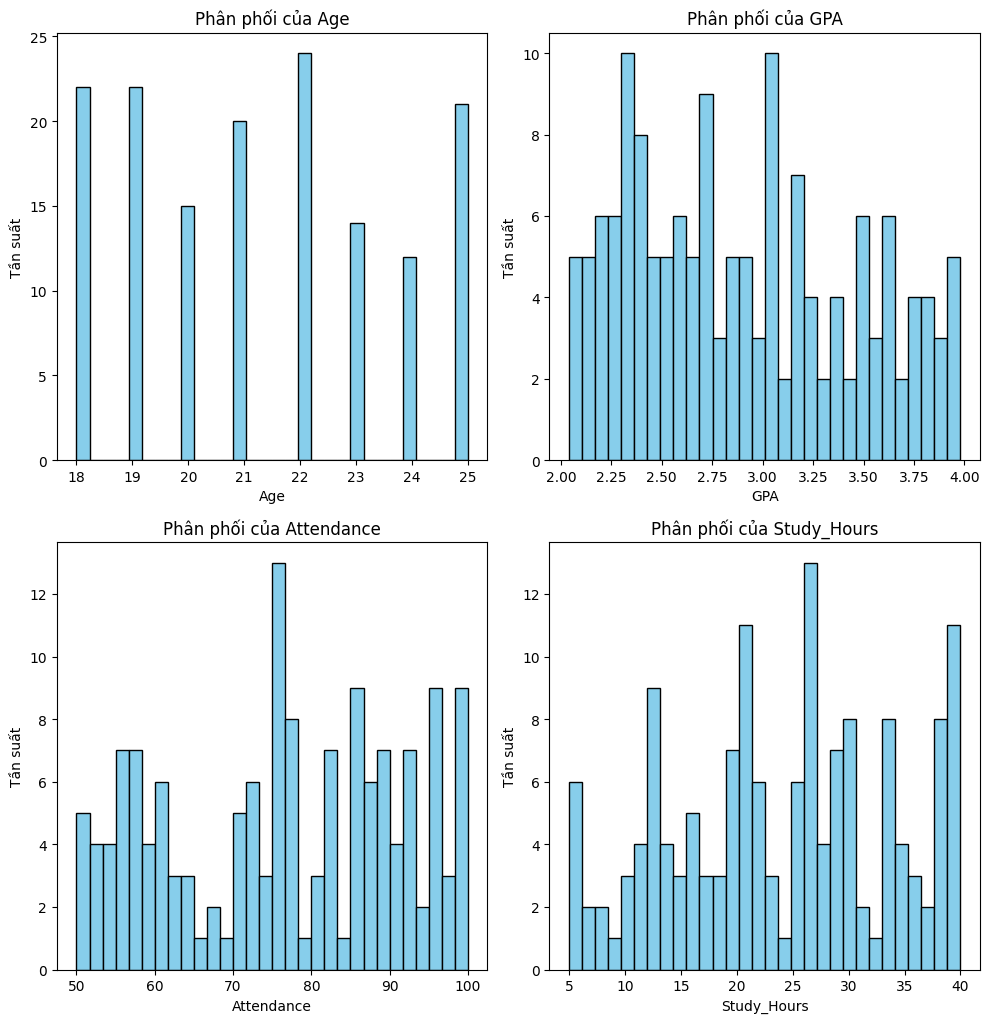

In [64]:
# Chọn các cột số, loại bỏ cột Pass (vì đây là cột mục tiêu phân loại)
numerical_columns = df.select_dtypes(include=['float', 'int']).columns
numerical_columns = [col for col in numerical_columns if col != 'Pass']  # Loại bỏ cột Pass
num_plots = len(numerical_columns)

# Setup số lượng hàng và cột
num_rows = 3
num_columns = math.ceil(num_plots / num_rows)

# Tạo khung lớn với số lượng hàng và cột phù hợp
fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 5, num_rows * 5))

# Lặp qua từng cột số và vẽ biểu đồ histogram
for i, column in enumerate(numerical_columns):
    row = i // num_columns
    col = i % num_columns
    
    # Vẽ biểu đồ histogram
    if num_rows > 1:
        axes[row, col].hist(df[column], bins=30, color='skyblue', edgecolor='black')
        axes[row, col].set_title(f'Phân phối của {column}')
        axes[row, col].set_xlabel(column)
        axes[row, col].set_ylabel('Tần suất')
    else:
        axes[col].hist(df[column], bins=30, color='skyblue', edgecolor='black')
        axes[col].set_title(f'Phân phối của {column}')
        axes[col].set_xlabel(column)
        axes[col].set_ylabel('Tần suất')

# Xóa các ô trống nếu có
if num_rows > 1:
    for j in range(i + 1, num_rows * num_columns):
        fig.delaxes(axes[j // num_columns, j % num_columns])
else:
    for j in range(i + 1, num_columns):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Phân tổ dữ liệu sử dụng hàm qcut từ thư viện pandas. Chia dữ liệu dựa trên phân vị

In [9]:
# Phân tổ các cột số (trừ Age) thành 5 nhóm bằng pd.qcut
df['GPA_LABEL'] = pd.qcut(df['GPA'], 5, labels=range(0, 5)).astype(int)
df['ATTENDANCE_LABEL'] = pd.qcut(df['Attendance'], 5, labels=range(0, 5)).astype(int)
df['STUDY_HOURS_LABEL'] = pd.qcut(df['Study_Hours'], 5, labels=range(0, 5)).astype(int)

### Trích xuất các cột cần sử dụng trong mô hình cây quyết định từ dataset

In [10]:
feature_columns = df[[
    'Age',               # Số
    'Gender',            # Phân loại
    'Major',             # Phân loại
    'Part_Time_Job',     # Phân loại
    'GPA_LABEL',         # Phân loại thay cho GPA
    'ATTENDANCE_LABEL',  # Phân loại thay cho Attendance
    'STUDY_HOURS_LABEL'  # Phân loại thay cho Study_Hours
]]

### Mã hóa các cột phân loại

In [15]:
# Mã hóa Gender và Part_Time_Job bằng replace
df['Gender'] = df['Gender'].replace({'Male': 1, 'Female': 0})
df['Part_Time_Job'] = df['Part_Time_Job'].replace({'Yes': 1, 'No': 0})

# Mã hóa Major bằng cách gán thủ công 0, 1, 2, 3, 4
df['Major'] = df['Major'].replace({
    'IT': 0,
    'Education': 1,
    'Engineering': 2,
    'Arts': 3,
    'Business': 4
})

# Mã hóa cột mục tiêu Pass
le = LabelEncoder()
df['Pass'] = le.fit_transform(df['Pass'])  # Yes/No -> 1/0



## 4. Chia dữ liệu thành tập huấn luyện và kiểm tra

In [13]:
X = df.drop('Pass', axis=1)  # Đặc trưng
y = df['Pass']  # Nhãn

# Chia dữ liệu: 80% huấn luyện, 20% kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 5. Tối ưu hóa tham số bằng Optuna

In [70]:
def objective(trial): #Tạo hàm có tên objective và hàm này nhận 1 tham số là trial
    #Xét giá trị cho các tham số của mô hình trong một khoảng chỉ định
    max_features = trial.suggest_int('max_features',4,20)
    max_depth = trial.suggest_int('max_depth', 4, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2,10)
    min_weight_fraction_leaf = trial.suggest_loguniform('min_weight_fraction_leaf', 0.01, 0.5)
    
    #Tạo mô hình cây quyết định với tham số thử nghiệm
    dt = tree.DecisionTreeClassifier(
        criterion='entropy',
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        random_state=42
    )
    #Đánh giá hiệu suất mô hình bằng kiểm định chéo
    scores = cross_val_score(dt, X_train, y_train, cv=5, scoring='accuracy')
    return scores.mean()
 #Tạo và chạy quá trình tối ưu hóa bằng Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Lấy và hiển thị tham số tốt nhất
best_params = study.best_params
print("\nTham số tốt nhất từ Optuna:", best_params)

[I 2025-05-02 01:12:50,925] A new study created in memory with name: no-name-f2d9b176-6214-4cd7-9103-4d13636b5a86
C:\Users\ACER\AppData\Local\Temp\ipykernel_7812\1611838839.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  min_weight_fraction_leaf = trial.suggest_loguniform('min_weight_fraction_leaf', 0.01, 0.5)
[I 2025-05-02 01:12:50,953] Trial 0 finished with value: 0.575 and parameters: {'max_features': 7, 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.014914686529546542}. Best is trial 0 with value: 0.575.
C:\Users\ACER\AppData\Local\Temp\ipykernel_7812\1611838839.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  min


Tham số tốt nhất từ Optuna: {'max_features': 5, 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 7, 'min_weight_fraction_leaf': 0.024145363553254372}


## 6. Xây dựng và huấn luyện mô hình với tham số tốt nhất

In [71]:
#Tạo mô hình cây quyết định với tham số tối ưu
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    min_weight_fraction_leaf = best_params['min_weight_fraction_leaf'],
    random_state=42
)
#Huấn luyện mô hình trên tập dữ liệu huấn luyện
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features=5,
                       min_samples_leaf=10, min_samples_split=7,
                       min_weight_fraction_leaf=0.024145363553254372,
                       random_state=42)

## 7. Trực quan hóa cây quyết định bằng plot_tree

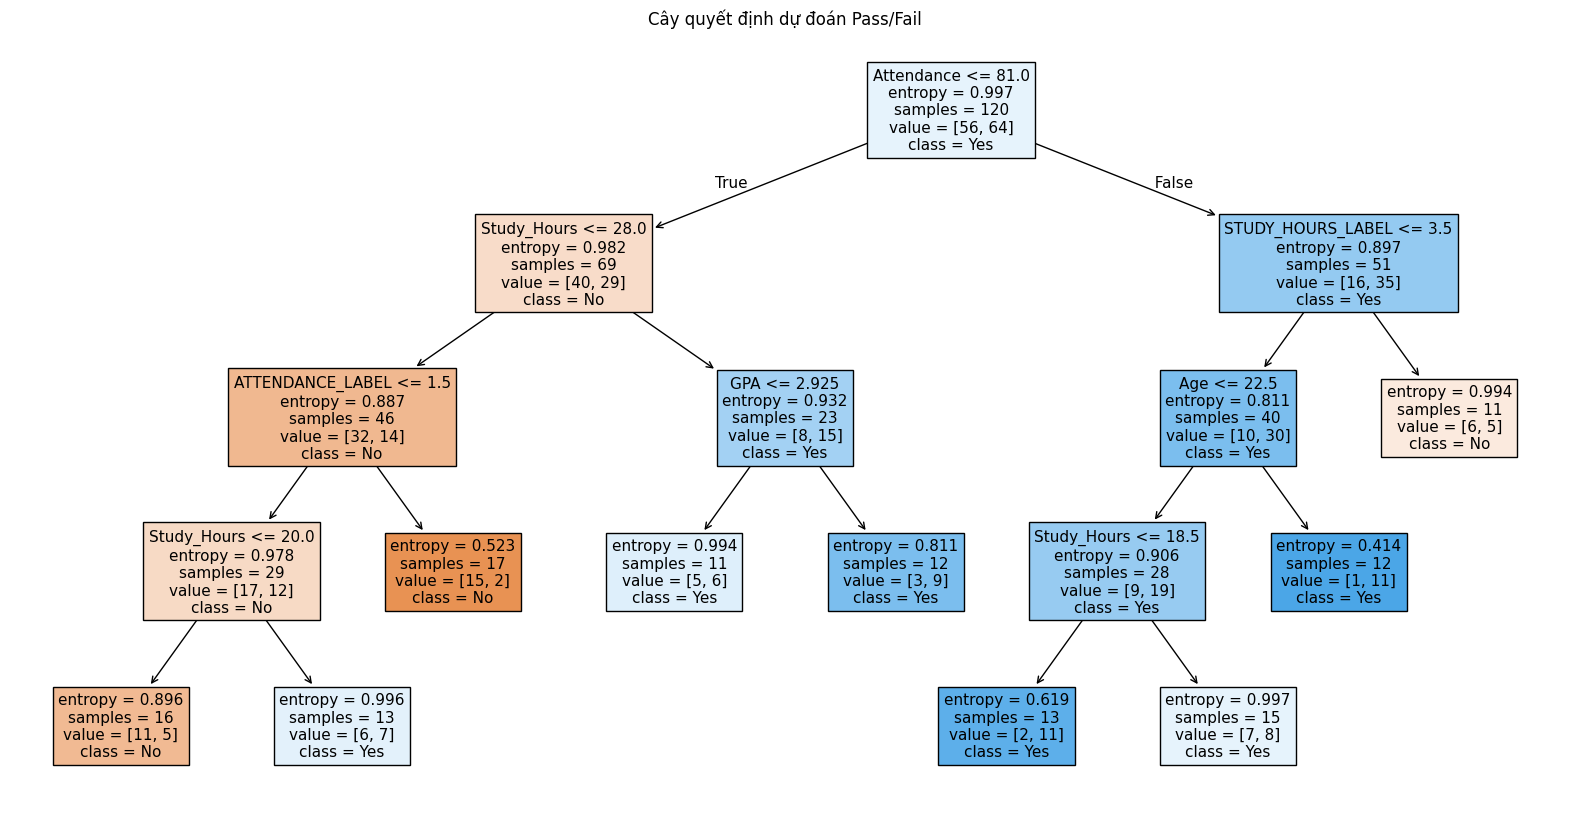

In [81]:
#Thiết lập kích thước biểu đồ
plt.figure(figsize=(20, 10))
tree.plot_tree(
    dt,
    fontsize=11,
    filled=True,
    feature_names=X.columns,
    class_names=['No', 'Yes']
)
#Đặt tên biểu đồ
plt.title('Cây quyết định dự đoán Pass/Fail')
plt.show()

## 8. Đánh giá mô hình

## Kiểm tra sự ổn định của mô hình thông qua kỹ thuật kiểm tra chéo 5 lần (k-fold cross-validation)

In [ ]:
print(cross_val_score(dt, X_train, y_train)) #Tham số cross validation mặc đinh là 5

[0.625      0.41666667 0.79166667 0.66666667 0.66666667]


## Dự đoán trên tập kiểm tra

In [74]:
y_pred = dt.predict(X_test)

## Độ chính xác

In [75]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nĐộ chính xác của mô hình: {accuracy:.2f}")


Độ chính xác của mô hình: 0.57


## Báo cáo phân loại (precision, recall, f1-score)

In [76]:
print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))


Báo cáo phân loại:
              precision    recall  f1-score   support

          No       0.42      0.45      0.43        11
         Yes       0.67      0.63      0.65        19

    accuracy                           0.57        30
   macro avg       0.54      0.54      0.54        30
weighted avg       0.57      0.57      0.57        30



## Ma trận nhầm lẫn

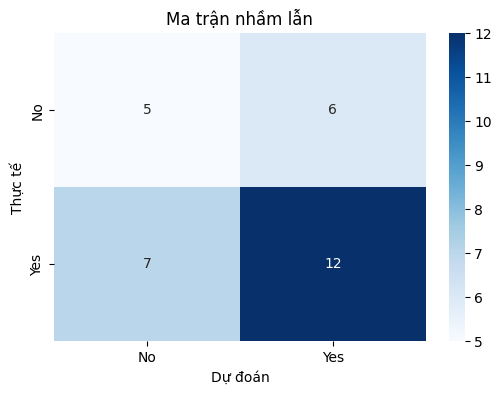

In [77]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Ma trận nhầm lẫn')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()

## Đánh giá độ quan trọng của các biến đầu vào trong mô hình

<Axes: >

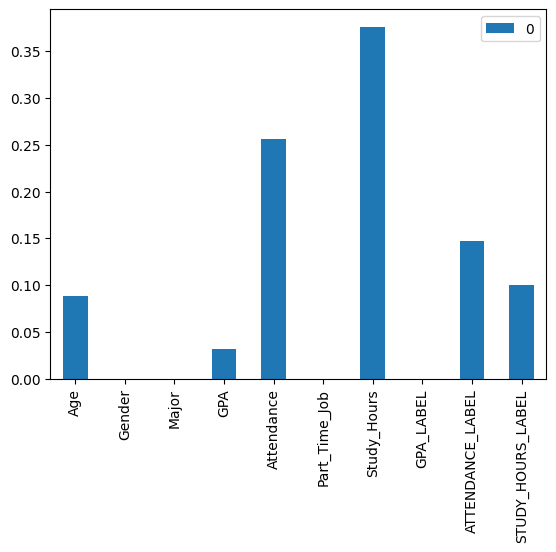

In [79]:
feature_importance=pd.DataFrame(dt.feature_importances_,index=X.columns)
feature_importance.plot(kind='bar')

# Xem các tham số đã dùng trong mô hình

In [80]:
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 5,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 7,
 'min_weight_fraction_leaf': 0.024145363553254372,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}